# SKLOE PyDAS

Copyright &copy; 2018

**Contributors:**
* Zhichao Fang
* Xiaoxian Guo

## 简介

基于Python3.6环境开发，主要针对FDAS处理后的数据，进行进一步后处理，实现数据读入，数据处理，数据输出。

FDAS主要对单个工况数据进行处理，我们希望基于python开发进一步的后处理工具，提高工作效率，并提供python接口，可以实现更多的实时功能。

主要应用场景：

- 针对不同工况，同一通道的数据横向对比分析
- 标准化的批量报表自动生成
- 标准化的数据后处理，针对刚度试验，衰减试验
- 便捷的自定义数据处理
- 应用于自动校波、校风

...


目前程序托管于GitHub，主页为：https://github.com/JosephFang/pydas


目前拥有以下功能：

1. out文件读入和保存
2. 打印文件基本信息到显示屏，txt文本，Excel文本 （包括：段数，通道数，采样频率，采样时间，前标定段信息，各个通道单位，通道名，系数，每段数据的采样点数，起止时间等）
3. 打印基本统计信息到显示屏，txt文本，Excel文本 （包括：最大值，最小值，方差，均值，点数等）
4. 输出数据至mat文件或.dat文件
5. 通道单位修复（原out文件通道单位不能超过4个字符）
6. 实型值转换
7. 简单的数据时域统计分析（基于Pandas）
8. 校波文件读入与波浪自动对齐相位

正在开发功能：

- 波浪数据频、时域分析（基于WAFO）
- 静刚度试验模块

待开发功能：

- 标准化报表自动生成（pdf,latex）
- 标准化波浪数据频域分析
- 标准化衰减试验模块

系统要求：

- Python >= 3.6.3
- Numpy >= 1.13
- Pandas >= 0.20.3
- Matplotlib >= 2.1.0
- Scipy >= 0.19.1

Windows下强烈推荐使用[Anaconda](https://www.anaconda.com)构建Python科学计算环境。

读入数据后，数据类型为pandas.DataFrame，基于pandas库的各种函数均可调用，请发挥你的想象力。

Pandas documents: https://pandas.pydata.org

后续版本将基于WAFO开发统计处理模块，包括时域分析，频谱转换，极值预报，统计模型检验，疲劳分析等。

强烈推荐WAFO模块（Matlab, Python）: http://www.maths.lth.se/matstat/wafo/

更多功能会陆续推出，欢迎大家在Github平台参与代码开发

如有任何问题请联系：[xiaoxguo@sjtu.edu.cn](mailto:xiaoxguo@sjtu.edu.cn)

## 运行环境检测与数据读入

In [1]:
# 读入skloe_out库，进行操作
from casedata import *
from statisana import *

# 导入必要的依赖库
import sys
import numpy as np
import pandas as pd
import matplotlib
import scipy

# this limit maximum numbers of rows
pd.set_option('display.max_rows', 10)
# 图片显示
%matplotlib inline

In [2]:
# 检查python 运行环境
print('Python version ' + sys.version)
print('Numpy version ' + np.__version__)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + matplotlib.__version__)
print('Scipy version ' + scipy.__version__)

Python version 3.6.4 (default, Jan  6 2018, 11:51:59) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]
Numpy version 1.14.0
Pandas version 0.22.0
Matplotlib version 2.1.2
Scipy version 1.0.0


In [3]:
# 读入.out文件
case = CaseData('test.out', sseg=1)

Reading file test.out... Done!


读入文件时可以选择读入所有段或指定数据段，默认读入所有数据段

如需读入某一个特定数据段：

```python
case = Skloe_OutFile('test.out', sseg=1) #读入第一段, 
```

注意，`sseg`从0开始计数，一般第0段为前标定段（若有前标定），第1段为第一段数据，仅有一段的文件则`sseg`为0

## 数据基本信息显示

读入out文件后，case可以直接查看一些信息，例如：

In [4]:
# 查看通道数
case.chN

3

这种方法，还可以查看以下相关信息：

- `case.segN`          数据段数
- `case.fs`            采样频率
- `case.scale`         数据类型 'prototype' or 'model'
- `case.filename`      读入数据文件名
- `case.date`          数据采样日期 MM-DD
- `case.data`          数据（采用`pandas.dataFrame`格式）
- `case.chInfo`        各个通道相关信息（通道号，通道名称，通道单位，通道转换系数）
- `case.segInfo`       各个数据段相关信息（段号，各段数据起止时间，采样数，采样时间，备注）
- `case.seg_statictis` 各段数据统计值显示（最大值，最小值，方程，均值）

In [5]:
# 查看通道信息
case.chInfo

,Name,Unit,Coef
1,wave.front,cm,0.000617
2,wave.center,cm,0.000771
3,wave.back,cm,0.000908


In [6]:
# 查看各个数据段信息
case.segInfo

,Type,Start,Stop,Duration,N sample,Note
Seg 1,0,13:59:34.0,14:00:14.3,39.7s,7950,1.00s-12.70cm-7.00m-22.00s


In [7]:
# 直接查看数据 第零段前5行
case.data[0].head(5)

,wave.front,wave.center,wave.back
0.000,-0.074040,0.038570,-0.010897
0.005,-0.052445,0.053998,-0.016346
0.010,-0.043190,0.053998,0.003632
0.015,-0.035786,0.040113,0.021794
0.020,-0.030850,0.023913,0.044497


## 数据调用相关

由于数据格式采用`pandas.DataFrame`格式，可以十分方便的进行数据引用，行索引为时间，列索引为通道名

数据引用采用以下格式：

```python
case.data[n]['channel name']
```

n为第几段数据，后面直接引用通道名即可，通道名部分还可以给`list`，如`['F.line1','wave1']`同时提取多列指定数据，更加丰富的数据索引方法，参见pandas支持文档。

基于此，可以直接利用pandas库丰富的内建函数，实现简单的数理统计，以下为一些例子，请发挥你的想象力：

pandas documents online:http://pandas.pydata.org/pandas-docs/stable/

In [8]:
#显示第1段数据所有通道平均值 
case.data[0].mean()

wave.front    -0.070272
wave.center   -0.124577
wave.back     -0.120691
dtype: float64

In [9]:
#显示第1段数据相关数理统计信息
case.data[0].describe()

,wave.front,wave.center,wave.back
count,7950.000000,7950.000000,7950.000000
mean,-0.070272,-0.124577,-0.120691
std,1.321669,1.438878,1.313419
min,-6.787000,-7.293587,-6.610968
25%,-0.193584,-0.269990,-0.264030
50%,-0.059232,-0.042427,-0.042681
75%,0.073423,0.038570,0.040864
max,7.745201,8.262465,8.137484


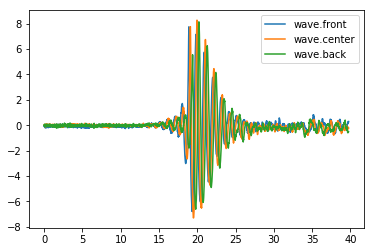

In [10]:
# 数据显示
case.data[0].plot()

## 数据导出

数据导出提供以下两个直接可以用的方法：

1. `case.to_dat(s_seg = 'all')` 默认导出所有段，或可导出指定段
2. `case.to_mat(s_seg = 0)` 这里请输入正整数，导出为包含该段所有信息的.mat文件

以上两种方法，生成的文件均保存在运行文件目录下。

除此之外，还可直接利用pandas函数导出特定段，特定通道数据，例如:

```python
case.data[0]['F.line1'].to_csv('sd1.dat') # 导出第0段F.line1到*.dat文件
```

这种情况下，可以转存数据到TXT，EXCEL，HTML...

数据段信息也可导出或查看，提供以下直接可用的方法(可以打印到显示屏，TXT，EXCEL(下一版本会支持打印到粘贴版)):

1. `case.pInfo(printTxt=False,printExcel=False)`打印段落信息
2. `case.pChInfo(printTxt=False,printExcel=False)`打印通道信息
3. `case.pst(printTxt=False,printExcel=False)`打印统计值信息


In [11]:
# 导出到*.dat
case.to_dat(sseg = 0)

# 导出到*.mat
case.to_mat(sseg = 0)

Export: /Users/zhichao/Research/Program/Python/pydas/test_seg00.txt
Export: /Users/zhichao/Research/Program/Python/pydas/testseg00.mat


## 实型值数据转换

目前可以根据输入各个通道单位，实现实型值转换，步骤如下：

1. 请检查读取单位是否有误，原out文件单位仅能占4个字节，故超过四个字节单位要修复，如deg/s2，kg.cm等

    检查通道：sd1.pChInfo()
    
    检查是否已经转换：sd1.scale

2. 修复单位，请用以下方法：sd1.fix_unit(c_chN=['Ch36','Ch35'],unit=['kg.cm','kg.cm']) #修改36，37通道单位为kg.cm
    
3. 转换数据到实型值：sd1.to_fullscale()

注意，一经转换所有信息将变为实型值，以上提到的针对数据处理的方法均可用，通道转换可识别所有常用单位。

In [12]:
case.fix_unit([1, 2], ['cm','cm'])

In [13]:
#case.to_fullscale()

In [14]:
case.pChInfo()

--------------------------------------------------
      Name     Unit    Coef  
1   wave.front  cm   0.000617
2  wave.center  cm   0.000771
3    wave.back  cm   0.000908
--------------------------------------------------


In [15]:
# save .out file
case.write('test-1.out', sseg='all')

Saving segment(s) No. [0] to file test-1.out


In [16]:
# Add channel
case.addCh('xxx', 'cm', np.zeros(case.data[0].shape[0]))
case.data[0]

,wave.front,wave.center,wave.back,xxx
0.000,-0.074040,0.038570,-0.010897,0.0
0.005,-0.052445,0.053998,-0.016346,0.0
0.010,-0.043190,0.053998,0.003632,0.0
0.015,-0.035786,0.040113,0.021794,0.0
0.020,-0.030850,0.023913,0.044497,0.0
...,...,...,...,...
39.725,0.283820,-0.195164,-0.544860,0.0
39.730,0.269012,-0.211364,-0.542136,0.0
39.735,0.244332,-0.240677,-0.524882,0.0
39.740,0.232609,-0.263819,-0.510352,0.0
